# RFM Churn

### DOMAIN: E-Commerce RFM Segmentation & Churn Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib  

In [3]:
rfm = pd.read_csv('rfm_segments.csv')
rfm

,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,1001,30,2,2320.0,2,1,5,215
1,1003,15,1,182.0,4,1,1,411
2,1004,28,3,1655.0,3,2,4,324
3,1005,3,1,738.0,5,1,2,512
4,1006,0,1,329.0,5,1,1,511
...,...,...,...,...,...,...,...,...
330,1491,28,1,329.0,3,1,1,311
331,1493,48,2,2155.0,1,1,5,115
332,1494,7,2,2341.0,5,1,5,515
333,1495,51,1,230.0,1,1,1,111


In [5]:
orders = pd.read_csv('orders.csv')
orders.columns

Index(['Order ID', 'Order Name', 'Created at', 'Financial Status',
       'Customer ID', 'Total Price', 'Subtotal Price', 'Total Discounts',
       'Shipping Cost', 'Total Tax', 'Lineitem quantity', 'Lineitem sku',
       'Lineitem price', 'Lineitem total price', 'Lineitem name', 'Refund ID',
       'Risk Level', 'Net Revenue', 'Fulfillment Cost', 'Contribution Margin',
       'Order Year', 'Order Month', 'Order week', 'Days Since Order',
       'First Purchase', 'Variant SKU', 'Cost per item', 'Lineitem COGS',
       'Lineitem Gross Profit', 'Gross Margin %'],
      dtype='object')

In [12]:
def segment_rfm(rfm):
    if rfm >= 541: return 'Champions (VIP)'
    elif rfm >= 421: return 'Loyal Customers'
    elif rfm >= 311: return 'Potential Loyalists'
    elif rfm >= 221: return 'At Risk'
    elif rfm >= 131: return 'About to Sleep (Churn Risk)'
    else: return 'Lost/Hibernating'
        
rfm['Segment'] = rfm['RFM_Score'].apply(segment_rfm)

In [29]:
print("\nRFM Segments Distribution:")
rfm['Segment'].value_counts().sort_index(ascending=False)


RFM Segments Distribution:


Segment
Potential Loyalists            122
Loyal Customers                 80
Lost/Hibernating                66
At Risk                          5
About to Sleep (Churn Risk)     62
Name: count, dtype: int64

In [28]:
seg_revenue = rfm.groupby('Segment')['Monetary'].agg(['count', 'sum', 'mean']).round(0)
seg_revenue['Revenue %'] = seg_revenue['sum'] / seg_revenue['sum'].sum() * 100
print("\nRevenue Contribution by Segment:")
seg_revenue


Revenue Contribution by Segment:


,count,sum,mean,Revenue %
Segment,,,,
About to Sleep (Churn Risk),62,52799.0,852.0,13.221036
At Risk,5,12697.0,2539.0,3.179369
Lost/Hibernating,66,62529.0,947.0,15.657459
Loyal Customers,80,124484.0,1556.0,31.171186
Potential Loyalists,122,146847.0,1204.0,36.770951


In [30]:
pivot_rfm = rfm.pivot_table(index='R_Score', columns='F_Score', values='Monetary', aggfunc='mean').round(0)
pivot_rfm

F_Score,1,2
R_Score,,
1,904.0,2347.0
2,852.0,2539.0
3,1053.0,2641.0
4,1185.0,2294.0
5,1154.0,2197.0


### Visualisation

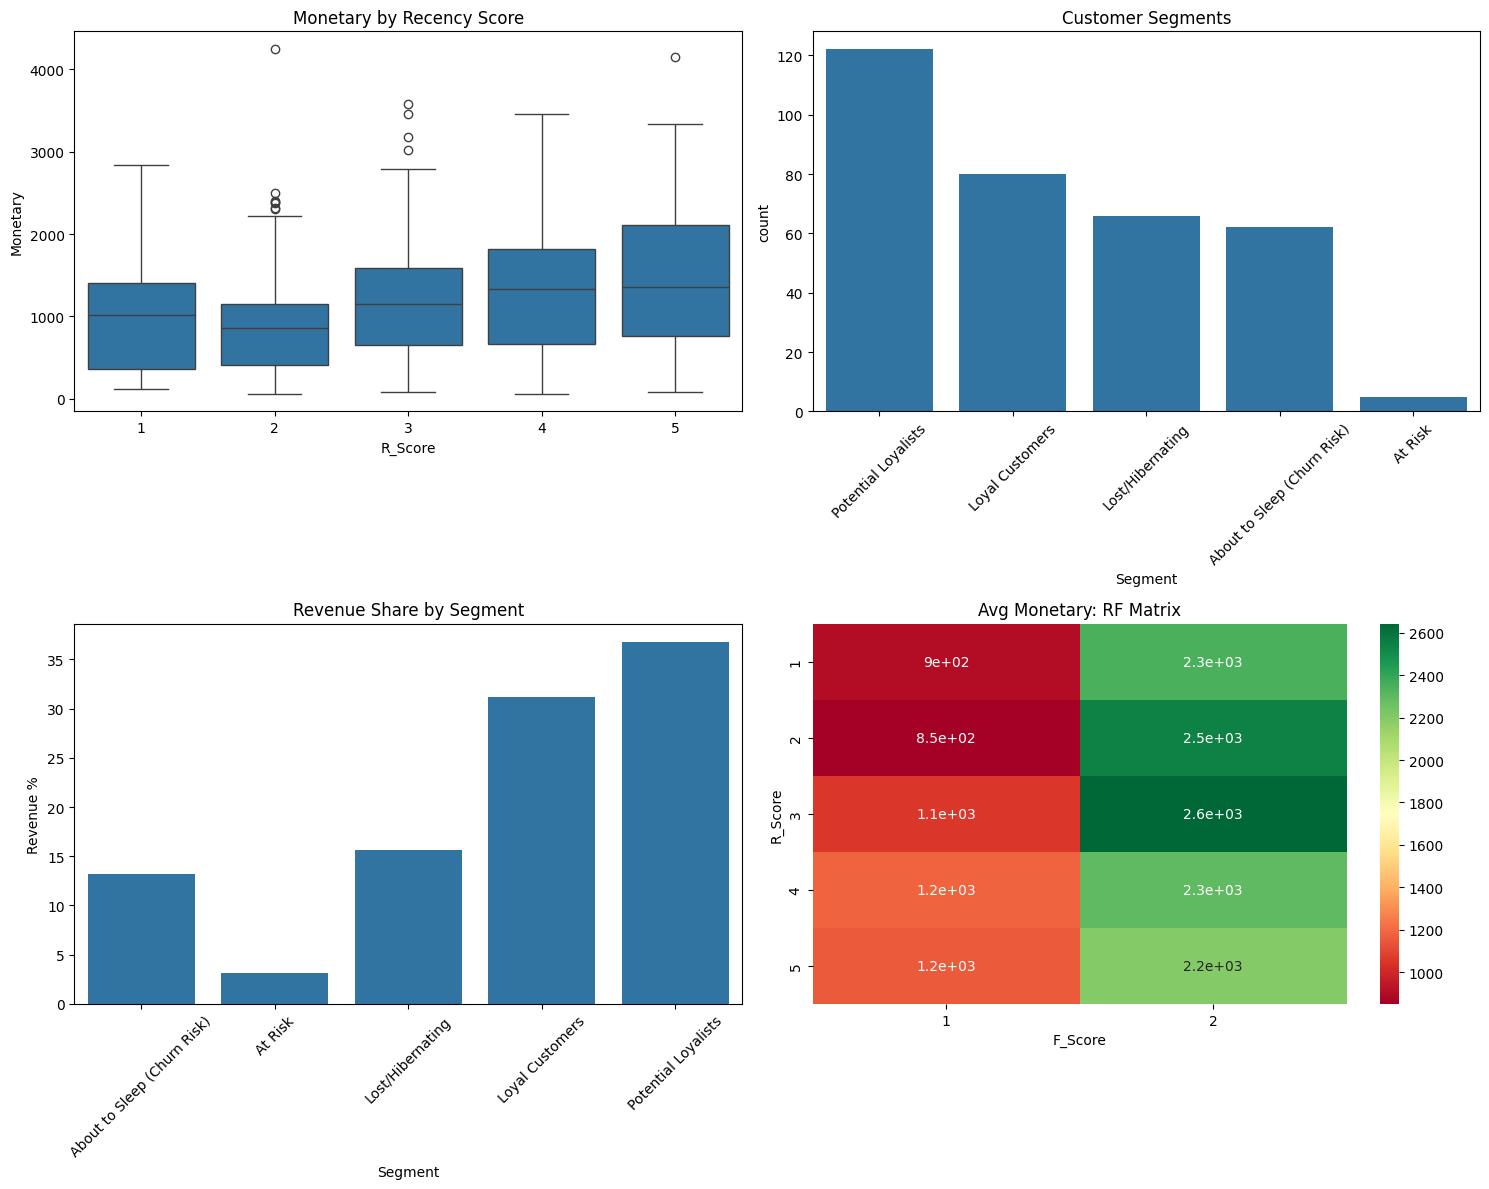

In [32]:
fig, axes = plt.subplots(2,2, figsize=(15,12))

sns.boxplot(data=rfm, x='R_Score', y='Monetary', ax=axes[0,0])
axes[0,0].set_title('Monetary by Recency Score')

sns.countplot(data=rfm, x='Segment', ax=axes[0,1], order=rfm['Segment'].value_counts().index)
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].set_title('Customer Segments')

sns.barplot(data=seg_revenue.reset_index(), x='Segment', y='Revenue %', ax=axes[1,0])
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].set_title('Revenue Share by Segment')

sns.heatmap(pivot_rfm, annot=True, cmap='RdYlGn', ax=axes[1,1])
axes[1,1].set_title('Avg Monetary: RF Matrix')

plt.tight_layout()
plt.savefig('rfm_visuals.png', dpi=300)
plt.show()

4. CHURN PREDICTION ML MODEL

In [61]:
rfm['Churned'] = (rfm['Recency'] > 30).astype(int)
rfm

,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,Churned
0,1001,30,2,2320.0,2,1,5,215,About to Sleep (Churn Risk),0
1,1003,15,1,182.0,4,1,1,411,Potential Loyalists,0
2,1004,28,3,1655.0,3,2,4,324,Potential Loyalists,0
3,1005,3,1,738.0,5,1,2,512,Loyal Customers,0
4,1006,0,1,329.0,5,1,1,511,Loyal Customers,0
...,...,...,...,...,...,...,...,...,...,...
330,1491,28,1,329.0,3,1,1,311,Potential Loyalists,0
331,1493,48,2,2155.0,1,1,5,115,Lost/Hibernating,1
332,1494,7,2,2341.0,5,1,5,515,Loyal Customers,0
333,1495,51,1,230.0,1,1,1,111,Lost/Hibernating,1


In [62]:
X = rfm[['Frequency', 'Monetary']]
Y = rfm['Churned']

In [63]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3,
random_state = 42, stratify=y)

In [67]:
rf_model = LogisticRegression()
rf_model.fit(X_train, Y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [68]:
Y_proba = rf_model.predict_proba(X_test)[:, 1]

In [69]:
print(f"ROC-AUC: {roc_auc_score(Y_test, Y_proba):.3f}")

ROC-AUC: 0.769


In [74]:
Y_test_shuffled = Y_test.sample(frac=1, random_state=42)

roc_auc_score(Y_test_shuffled, Y_proba)

0.5111662531017369

In [79]:
importances = pd.DataFrame({
    'Feature': ['Frequency', 'Monetary'],
    'Coefficient': rf_model.coef_[0]
}).sort_values('Coefficient', ascending=False)
print("\nFeature Coefficients:")
print(importances)


Feature Coefficients:
     Feature  Coefficient
1   Monetary    -0.000013
0  Frequency    -0.829040


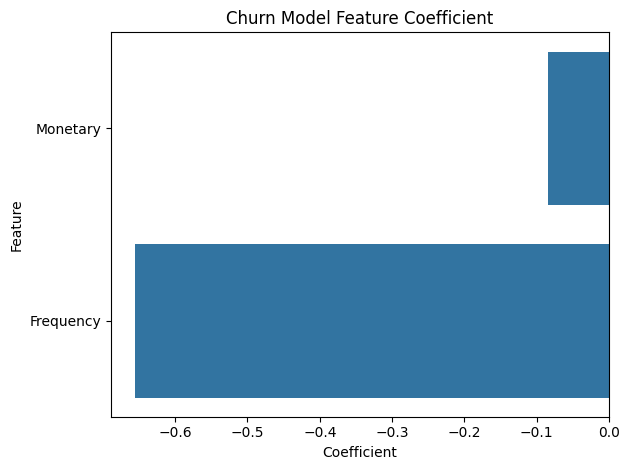

In [85]:
sns.barplot(data=coef_df, x='Coefficient', y='Feature')
plt.title('Churn Model Feature Coefficient')
plt.tight_layout()
plt.savefig('churn_coefficients.png')
plt.show()

In [87]:
joblib.dump(rf_model, 'churn_model.pkl')
joblib.dump(coef_df, 'feature_coefficients.pkl')

['feature_coefficients.pkl']